# Условие


В качестве домашнего задания вам предлагается поработать над предсказанием погоды в Австралии. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weatherAUS.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 3 модели которые будут предсказывать целевую переменную RainTomorrow:

    С помощью Байесовских классификаторов
    С помощью логистической регрессии
    С помощью метода ближайших соседей

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.
В конце ноутбука должны быть четко описаны полученные результаты и метрики.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра
  

# Data Prepocessing


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [ ]:
df = pd.read_csv('weatherAUS.csv')

## Date

In [ ]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


Проверим сколько процентов данных пропущено в каждом столбце 

In [ ]:
df.isnull().sum().sort_values()/df.shape[0]

Date             0.000000
Location         0.000000
MaxTemp          0.008669
MinTemp          0.010209
Temp9am          0.012148
WindSpeed9am     0.012148
Humidity9am      0.018246
WindSpeed3pm     0.021050
Rainfall         0.022419
RainToday        0.022419
RainTomorrow     0.022460
Temp3pm          0.024811
WindDir3pm       0.029066
Humidity3pm      0.030984
WindGustSpeed    0.070555
WindGustDir      0.070989
WindDir9am       0.072639
Pressure3pm      0.103314
Pressure9am      0.103568
Cloud9am         0.384216
Cloud3pm         0.408071
Evaporation      0.431665
Sunshine         0.480098
dtype: float64

У столбцов Cloud, Sunshine, Evaporation более 38% данных нет. Если их заполнять средним, это может сильно исказить результат. Уберем их

In [ ]:
df.drop(columns=['Sunshine', 'Evaporation', 'Cloud9am', 'Cloud3pm'], inplace=True)

Разобьем колонку Date на отдельные столбцы: День, Месяц, Год

In [ ]:
df['Month'] = [int(i.split('-')[1]) for i in df['Date']]
df['Year'] = [int(i.split('-')[0]) for i in df['Date']]
df['Day'] = [int(i.split('-')[2]) for i in df['Date']]
df.drop(columns=['Date'], inplace=True)

In [ ]:
df

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Day
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,12,2008,1
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,12,2008,2
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,12,2008,3
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,12,2008,4
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,12,2008,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No,6,2017,21
145456,Uluru,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No,6,2017,22
145457,Uluru,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No,6,2017,23
145458,Uluru,7.8,27.0,0.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,15.1,26.0,No,No,6,2017,24


## Location

Location - категориальный список, вспользуемся LabelEncoder'ом

In [ ]:
df['Location'].describe()

count       145460
unique          49
top       Canberra
freq          3436
Name: Location, dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
le.fit(df['Location'].unique())

LabelEncoder()

In [ ]:
df['Location'] = le.transform(df['Location'])

In [ ]:
#ones = pd.get_dummies(df.Location, prefix='Loc')
#ones

In [ ]:
#df = df.join(ones)

In [ ]:
#df = df.drop('Location', axis=1)
df

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Day
0,2,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,12,2008,1
1,2,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,12,2008,2
2,2,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,12,2008,3
3,2,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,12,2008,4
4,2,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,12,2008,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,41,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No,6,2017,21
145456,41,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No,6,2017,22
145457,41,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No,6,2017,23
145458,41,7.8,27.0,0.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,15.1,26.0,No,No,6,2017,24


## Temperature

Проверим сколько ячеек пустых и есть ли они, и если есть заполним NaN значения используя метод инетрполяции



In [ ]:
print(df['MaxTemp'].isnull().sum())
print(df['MinTemp'].isnull().sum())
print(df['Temp9am'].isnull().sum())
print(df['Temp3pm'].isnull().sum())

1261
1485
1767
3609


In [ ]:
df['MaxTemp'].interpolate(method='linear', inplace=True, limit_direction ='forward')
df['Temp3pm'].interpolate(method='linear', inplace=True, limit_direction ='forward')
df['Temp9am'].interpolate(method='linear', inplace=True, limit_direction ='forward')
df['MinTemp'].interpolate(method='linear', inplace=True, limit_direction ='forward')


In [ ]:
df['MaxTemp'].interpolate(method='linear', inplace=True, limit_direction ='backward')
df['Temp3pm'].interpolate(method='linear', inplace=True, limit_direction ='backward')
df['Temp9am'].interpolate(method='linear', inplace=True, limit_direction ='backward')
df['MinTemp'].interpolate(method='linear', inplace=True, limit_direction ='backward')

Введем дополнительный столбец средней температуры за день. И удалим столбцы минимальной и максимальной температуры за день. 

In [ ]:
df['MeanTemp'] = (df['MaxTemp'] + df['MinTemp'] + df['Temp9am'] + df['Temp3pm'])/2
df.drop(columns=['MaxTemp', 'MinTemp'], inplace=True)
df

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Day,MeanTemp
0,2,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,12,2008,1,37.50
1,2,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,12,2008,2,37.00
2,2,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,12,2008,3,41.40
3,2,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,12,2008,4,40.90
4,2,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,12,2008,5,48.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,41,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No,6,2017,21,29.35
145456,41,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No,6,2017,22,32.15
145457,41,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No,6,2017,23,35.45
145458,41,0.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,15.1,26.0,No,No,6,2017,24,37.95


In [ ]:
# df.drop(columns=['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm'], inplace=True)

## Rainfall

In [ ]:
df['Rainfall'].describe()

count    142199.000000
mean          2.360918
std           8.478060
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: Rainfall, dtype: float64

In [ ]:
df['Rainfall'].isnull().sum()

3261

In [ ]:
# df['Rainfall'].fillna(df['Rainfall'].mean(), inplace=True)
df['Rainfall'].interpolate(method='linear', inplace=True, limit_direction ='forward')

In [ ]:
df['Rainfall'].interpolate(method='linear', inplace=True, limit_direction ='backward')

In [ ]:
df

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Day,MeanTemp
0,2,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,12,2008,1,37.50
1,2,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,12,2008,2,37.00
2,2,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,12,2008,3,41.40
3,2,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,12,2008,4,40.90
4,2,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,12,2008,5,48.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,41,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No,6,2017,21,29.35
145456,41,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No,6,2017,22,32.15
145457,41,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No,6,2017,23,35.45
145458,41,0.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,15.1,26.0,No,No,6,2017,24,37.95


## Wind

Направление ветра - категориальный признак, используем LabelEncoding, но сперва нужно заполнить пустые ячейки

In [ ]:
df.WindGustDir.isnull().sum()

10326

In [ ]:
#ones = pd.get_dummies(df.WindGustDir, prefix='WindDir')
#ones

In [ ]:
df['WindGustDir'].fillna(method='ffill', inplace=True)

In [ ]:
df.WindGustDir.unique()

array(['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE',
       'S', 'NW', 'SE', 'ESE', 'E', 'SSW'], dtype=object)

In [ ]:
wind_le = LabelEncoder()
wind_le.fit(df['WindGustDir'].unique())
df['WindGustDir'] = wind_le.transform(df['WindGustDir'])

In [ ]:
df

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Day,MeanTemp
0,2,0.6,13,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,12,2008,1,37.50
1,2,0.0,14,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,12,2008,2,37.00
2,2,0.0,15,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,12,2008,3,41.40
3,2,0.0,4,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,12,2008,4,40.90
4,2,1.0,13,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,12,2008,5,48.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,41,0.0,0,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No,6,2017,21,29.35
145456,41,0.0,6,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No,6,2017,22,32.15
145457,41,0.0,3,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No,6,2017,23,35.45
145458,41,0.0,9,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,15.1,26.0,No,No,6,2017,24,37.95


In [ ]:
df['WindDir3pm'].fillna(method='ffill', inplace=True)
df['WindDir9am'].fillna(method='ffill', inplace=True)

In [ ]:
df['WindDir3pm'] = wind_le.transform(df['WindDir3pm'])

In [ ]:
df['WindDir9am'] = wind_le.transform(df['WindDir9am'])

In [ ]:
#df = df.drop('WindGustDir', axis=1)
df

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Day,MeanTemp
0,2,0.6,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,12,2008,1,37.50
1,2,0.0,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,12,2008,2,37.00
2,2,0.0,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,12,2008,3,41.40
3,2,0.0,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,12,2008,4,40.90
4,2,1.0,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,12,2008,5,48.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,41,0.0,0,31.0,9,1,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No,6,2017,21,29.35
145456,41,0.0,6,22.0,9,3,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No,6,2017,22,32.15
145457,41,0.0,3,37.0,9,14,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No,6,2017,23,35.45
145458,41,0.0,9,28.0,10,3,13.0,7.0,51.0,24.0,1019.4,1016.5,15.1,26.0,No,No,6,2017,24,37.95


In [ ]:
df['WindGustSpeed'].describe()

count    135197.000000
mean         40.035230
std          13.607062
min           6.000000
25%          31.000000
50%          39.000000
75%          48.000000
max         135.000000
Name: WindGustSpeed, dtype: float64

In [ ]:
df.WindGustSpeed.isnull().sum()

10263

Пустые ячейки скорость ветра заполним методом интерполяции

In [ ]:
# df['WindGustSpeed'].fillna(df['WindGustSpeed'].mean(), inplace=True)
df['WindGustSpeed'].interpolate(method='linear', inplace=True, limit_direction ='forward')

In [ ]:
df['WindGustSpeed'].interpolate(method='linear', inplace=True, limit_direction ='backward')

In [ ]:
df['WindDir9am'].describe()

count    145460.000000
mean          7.331864
std           4.520546
min           0.000000
25%           3.000000
50%           7.000000
75%          11.000000
max          15.000000
Name: WindDir9am, dtype: float64

In [ ]:
#df['WindDir9am'].isnull().sum()

In [ ]:
#ones = pd.get_dummies(df.WindDir9am, prefix='WindDir9am')
#df = df.join(ones)


In [ ]:
#df = df.drop('WindDir9am', axis=1)


In [ ]:
#ones = pd.get_dummies(df.WindDir3pm, prefix='WindDir3pm')
#df = df.join(ones)

In [ ]:
#df = df.drop('WindDir3pm', axis=1)


In [ ]:
# df['WindSpeed3pm'].fillna(df['WindSpeed3pm'].mean(), inplace=True)
df['WindSpeed3pm'].interpolate(method='linear', inplace=True, limit_direction ='forward')
df['WindSpeed3pm'].interpolate(method='linear', inplace=True, limit_direction ='backward')

In [ ]:
# df['WindSpeed9am'].fillna(df['WindSpeed9am'].mean(), inplace=True)

df['WindSpeed9am'].interpolate(method='linear', inplace=True, limit_direction ='forward')
df['WindSpeed9am'].interpolate(method='linear', inplace=True, limit_direction ='backward')

## Humidity and Pressure


Влажность и давление. Запоним пустые ячейки с помощью метода интерполяции, введем дополнительно столбцы средней влажности и среднего давления

In [ ]:
# df.drop(columns=['Humidity3pm', 'Humidity9am'], inplace=True)

In [ ]:
df['Humidity3pm'].interpolate(method='linear', inplace=True, limit_direction ='forward')
df['Humidity3pm'].interpolate(method='linear', inplace=True, limit_direction ='backward')
df['Pressure9am'].interpolate(method='linear', inplace=True, limit_direction ='forward')
df['Pressure9am'].interpolate(method='linear', inplace=True, limit_direction ='backward')
df['Humidity9am'].interpolate(method='linear', inplace=True, limit_direction ='forward')
df['Humidity9am'].interpolate(method='linear', inplace=True, limit_direction ='backward')
df['Pressure3pm'].interpolate(method='linear', inplace=True, limit_direction ='forward')
df['Pressure3pm'].interpolate(method='linear', inplace=True, limit_direction ='backward')

In [ ]:
df['MeanHumudity'] = (df['Humidity3pm']+df['Humidity9am'])/2

In [ ]:
df['Humidity9am'].describe()

count    145460.000000
mean         68.903809
std          19.056628
min           0.000000
25%          57.000000
50%          70.000000
75%          83.000000
max         100.000000
Name: Humidity9am, dtype: float64

In [ ]:
df['MeanPressure'] = (df['Pressure3pm']+df['Pressure9am'])/2

In [ ]:
# df.drop(columns=['Humidity9am', 'Pressure9am', 'Humidity3pm', 'Pressure3pm'], inplace=True)

In [ ]:
# df.drop(columns=['Pressure9am', 'Pressure3pm'], inplace=True)

## Rain

Проанализируем признак, который мы будем предсказывать


In [ ]:
df['RainTomorrow'].isnull().sum()

3267

In [ ]:
df['RainTomorrow'].isnull().sum()/len(df)

0.02245978275814657

Есть пустые ячейки и они составляют два процента. Мы можем выбросить строки, в которых отсутствуют данные о дожде завтра

In [ ]:
df = df[df['RainTomorrow'].notna()]

In [ ]:
y_data = df['RainTomorrow'].copy()

In [ ]:
df

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Day,MeanTemp,MeanHumudity,MeanPressure
0,2,0.6,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,12,2008,1,37.50,46.5,1007.40
1,2,0.0,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,12,2008,2,37.00,34.5,1009.20
2,2,0.0,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,12,2008,3,41.40,34.0,1008.15
3,2,0.0,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,12,2008,4,40.90,30.5,1015.20
4,2,1.0,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,12,2008,5,48.65,57.5,1008.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,41,0.0,0,31.0,2,0,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No,No,6,2017,20,27.80,43.0,1022.95
145455,41,0.0,0,31.0,9,1,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No,6,2017,21,29.35,37.5,1022.45
145456,41,0.0,6,22.0,9,3,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No,6,2017,22,32.15,38.5,1021.30
145457,41,0.0,3,37.0,9,14,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No,6,2017,23,35.45,38.5,1018.90


In [ ]:
df['RainToday'].unique()

array(['No', 'Yes', nan], dtype=object)

In [ ]:
df['RainToday'].isnull().sum()

1406

In [ ]:
df['RainToday'].value_counts()

No     109332
Yes     31455
Name: RainToday, dtype: int64

В столбце RainToday присутствуют пустые ячейки, заполним их методом интерполяции

In [ ]:
#df['RainToday'].fillna(0, inplace=True)
df['RainToday'].interpolate(method='linear', inplace=True, limit_direction ='forward')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df['RainToday'].interpolate(method='linear', inplace=True, limit_direction ='backward')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Преобразуем текстовые данные в 1 и 0

In [ ]:
def transform(data):
  if data == 'No':
    return 0
  else:
    return 1
df['RainToday'] = [transform(i) for i in df['RainToday']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [ ]:
df['RainTomorrow'] = [transform(i) for i in df['RainTomorrow']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Day,MeanTemp,MeanHumudity,MeanPressure
0,2,0.6,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0,12,2008,1,37.50,46.5,1007.40
1,2,0.0,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0,12,2008,2,37.00,34.5,1009.20
2,2,0.0,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0,12,2008,3,41.40,34.0,1008.15
3,2,0.0,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0,12,2008,4,40.90,30.5,1015.20
4,2,1.0,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0,12,2008,5,48.65,57.5,1008.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,41,0.0,0,31.0,2,0,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,0,0,6,2017,20,27.80,43.0,1022.95
145455,41,0.0,0,31.0,9,1,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,0,0,6,2017,21,29.35,37.5,1022.45
145456,41,0.0,6,22.0,9,3,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,0,0,6,2017,22,32.15,38.5,1021.30
145457,41,0.0,3,37.0,9,14,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,0,0,6,2017,23,35.45,38.5,1018.90


In [ ]:
df.columns

Index(['Location', 'Rainfall', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm',
       'RainToday', 'RainTomorrow', 'Month', 'Year', 'Day', 'MeanTemp',
       'MeanHumudity', 'MeanPressure'],
      dtype='object')

Проверим, остались ли пустые данные в таблице

In [ ]:
df.isnull().sum().sort_values()/df.shape[0]

Location         0.0
MeanTemp         0.0
Day              0.0
Year             0.0
Month            0.0
RainTomorrow     0.0
RainToday        0.0
Temp3pm          0.0
Temp9am          0.0
Pressure3pm      0.0
Pressure9am      0.0
Humidity3pm      0.0
Humidity9am      0.0
WindSpeed3pm     0.0
WindSpeed9am     0.0
WindDir3pm       0.0
WindDir9am       0.0
WindGustSpeed    0.0
WindGustDir      0.0
Rainfall         0.0
MeanHumudity     0.0
MeanPressure     0.0
dtype: float64

# Normalization


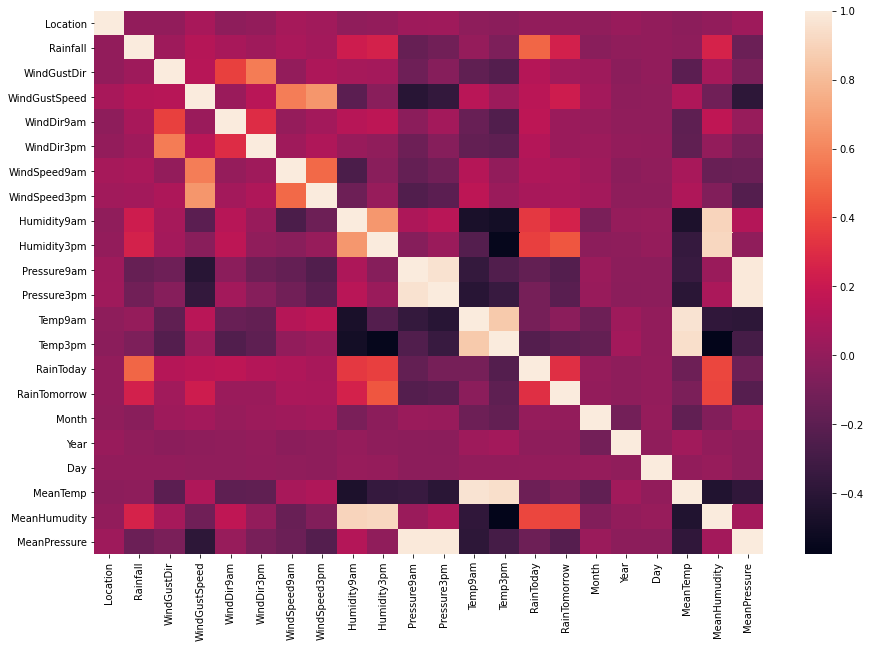

In [ ]:
import seaborn as sns
corr = df.corr()
fig = plt.figure(figsize=(15,10))
sns.heatmap(corr)

In [ ]:
y = df.pop('RainTomorrow')


In [ ]:
X = df.copy()

In [ ]:
X

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,Month,Year,Day,MeanTemp,MeanHumudity,MeanPressure
0,2,0.6,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,12,2008,1,37.50,46.5,1007.40
1,2,0.0,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,12,2008,2,37.00,34.5,1009.20
2,2,0.0,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,12,2008,3,41.40,34.0,1008.15
3,2,0.0,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,12,2008,4,40.90,30.5,1015.20
4,2,1.0,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,12,2008,5,48.65,57.5,1008.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,41,0.0,0,31.0,2,0,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,0,6,2017,20,27.80,43.0,1022.95
145455,41,0.0,0,31.0,9,1,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,0,6,2017,21,29.35,37.5,1022.45
145456,41,0.0,6,22.0,9,3,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,0,6,2017,22,32.15,38.5,1021.30
145457,41,0.0,3,37.0,9,14,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,0,6,2017,23,35.45,38.5,1018.90


In [ ]:
X.shape

(142193, 21)

In [ ]:
y.shape

(142193,)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
colls_to_norm = X.columns
X[colls_to_norm] = MinMaxScaler().fit_transform(X[colls_to_norm])

In [ ]:
X

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,Month,Year,Day,MeanTemp,MeanHumudity,MeanPressure
0,0.041667,0.001617,0.866667,0.294574,0.866667,0.933333,0.153846,0.275862,0.71,0.22,0.449587,0.4800,0.508439,0.522073,0.0,1.000000,0.1,0.000000,0.537964,0.465,0.458541
1,0.041667,0.000000,0.933333,0.294574,0.400000,1.000000,0.030769,0.252874,0.44,0.25,0.497521,0.4912,0.514768,0.570058,0.0,1.000000,0.1,0.033333,0.532579,0.345,0.488391
2,0.041667,0.000000,1.000000,0.310078,0.866667,1.000000,0.146154,0.298851,0.38,0.30,0.447934,0.5056,0.594937,0.548944,0.0,1.000000,0.1,0.066667,0.579968,0.340,0.470978
3,0.041667,0.000000,0.266667,0.139535,0.600000,0.000000,0.084615,0.103448,0.45,0.16,0.613223,0.5712,0.533755,0.612284,0.0,1.000000,0.1,0.100000,0.574583,0.305,0.587894
4,0.041667,0.002695,0.866667,0.271318,0.066667,0.466667,0.053846,0.229885,0.82,0.33,0.500826,0.4624,0.527426,0.673704,0.0,1.000000,0.1,0.133333,0.658051,0.575,0.475124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,0.854167,0.000000,0.000000,0.193798,0.133333,0.000000,0.115385,0.149425,0.59,0.27,0.730579,0.7056,0.350211,0.504798,0.0,0.454545,1.0,0.633333,0.433495,0.430,0.716418
145455,0.854167,0.000000,0.000000,0.193798,0.600000,0.066667,0.100000,0.126437,0.51,0.24,0.728926,0.6912,0.364979,0.533589,0.0,0.454545,1.0,0.666667,0.450188,0.375,0.708126
145456,0.854167,0.000000,0.400000,0.124031,0.600000,0.200000,0.100000,0.103448,0.56,0.21,0.710744,0.6720,0.381857,0.573896,0.0,0.454545,1.0,0.700000,0.480345,0.385,0.689055
145457,0.854167,0.000000,0.200000,0.240310,0.600000,0.933333,0.069231,0.103448,0.53,0.24,0.669421,0.6352,0.415612,0.604607,0.0,0.454545,1.0,0.733333,0.515886,0.385,0.649254


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False)

# С помощью Байесовских классификаторов


In [ ]:
%%time
from sklearn.naive_bayes import  GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)
print('Accuracy - ',np.mean(prediction == y_test))
print('Precision - ',precision_score(y_test, prediction))
print('Recall - ',recall_score(y_test, prediction))
print('F1 - ', f1_score(y_test, prediction))
print('ROC-AUC - ',roc_auc_score(y_test, prediction))

Accuracy -  0.8343132014965259
Precision -  0.6357524828113064
Recall -  0.5427155341072127
F1 -  0.5855614973262032
ROC-AUC -  0.7286061710418426
CPU times: user 123 ms, sys: 1.81 ms, total: 125 ms
Wall time: 123 ms


# С помощью логистической регрессии


In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C": [0.01,0.1,1,10,100], "penalty":["l1","l2", "elasticnet"], 
      'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
logreg=LogisticRegression(max_iter = 5000)
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

prediction = logreg_cv.predict(X_test)


print('Accuracy - ',np.mean(prediction == y_test))
print('Precision - ',precision_score(y_test, prediction))
print('Recall - ',recall_score(y_test, prediction))
print('F1 - ', f1_score(y_test, prediction))
print('ROC-AUC - ',roc_auc_score(y_test, prediction))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
accuracy : 0.8320957639198829
Accuracy -  0.8479000815775408
Precision -  0.7720269619643717
Recall -  0.41828616147124037
F1 -  0.5425936891971913
ROC-AUC -  0.6921607982594707
CPU times: user 50min 13s, sys: 3min 50s, total: 54min 4s
Wall time: 47min 53s


In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty =  'l1', max_iter = 500, solver='saga', C=0.1)
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

print('Accuracy - ',np.mean(prediction == y_test))
print('Precision - ',precision_score(y_test, prediction))
print('Recall - ',recall_score(y_test, prediction))
print('F1 - ', f1_score(y_test, prediction))
print('ROC-AUC - ',roc_auc_score(y_test, prediction))

Accuracy -  0.8479000815775408
Precision -  0.7720269619643717
Recall -  0.41828616147124037
F1 -  0.5425936891971913
ROC-AUC -  0.6921607982594707
CPU times: user 1.48 s, sys: 90.9 ms, total: 1.57 s
Wall time: 1.48 s


# С помощью метода ближайших соседей

Используем GridSearch для поиска оптимальных параметров для KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

grid={"n_neighbors":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
classifier = KNeighborsClassifier()
knn_cv=GridSearchCV(classifier,grid,cv=10)
knn_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

prediction = knn_cv.predict(X_test)

print('Accuracy - ',np.mean(prediction == y_test))
print('Precision - ',precision_score(y_test, prediction))
print('Recall - ',recall_score(y_test, prediction))
print('ROC-AUC - ',roc_auc_score(y_test, prediction))

tuned hpyerparameters :(best parameters)  {'n_neighbors': 15}
accuracy : 0.8180677834718877
Accuracy -  0.8318940054572562
Precision -  0.734795890030547
Recall -  0.3451154297639233
ROC-AUC -  0.6554319706742291


In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=15)
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

print('Accuracy - ',np.mean(prediction == y_test))
print('Precision - ',precision_score(y_test, prediction))
print('Recall - ',recall_score(y_test, prediction))
print('F1 - ', f1_score(y_test, prediction))
print('ROC-AUC - ',roc_auc_score(y_test, prediction))

Accuracy -  0.8318940054572562
Precision -  0.734795890030547
Recall -  0.3451154297639233
F1 -  0.4696485623003195
ROC-AUC -  0.6554319706742291
CPU times: user 1min 24s, sys: 83.3 ms, total: 1min 25s
Wall time: 1min 24s


# Итого

Посмотрим соотношение классов в результирующей переменной

In [ ]:
y_data.value_counts()/len(y_data) * 100

No     77.581878
Yes    22.418122
Name: RainTomorrow, dtype: float64

Так как соотношение классов неравное, то метрика Accuracy тут бесполезна. Ориентироваться можно на Presicion, Recall, F1

## Байесовский классификатор


Accuracy -  0.8343132014965259

Precision -  0.7708682133460895

Recall -  0.42037302725968434

F1 -  0.5440580688723835

ROC-AUC -  0.6930069712727659

CPU times: user 1.96 s, sys: 99.3 ms, total: 2.06 s

Время выполнения: 2.04 s

## Логистическая регрессия


GridSearch показал наилучший параметры для логистической регрессии - 'C': 0.1, 'penalty': 'l1', 'solver': 'saga'

На тренировочном наборе показал:
Accuracy : 0.8320957639198829



На тестовой выборке метрики получились такие:

Accuracy -  0.8479000815775408

Precision -  0.7720269619643717

Recall -  0.41828616147124037

F1 -  0.5425936891971913

ROC-AUC -  0.6921607982594707

CPU times: user 1.96 s, sys: 99.3 ms, total: 2.06 s

Время выполнения: 2.04 s

## Метод ближайших соседей

GridSearch показал наилучший параметр для количества ближайших сосдей - 15, и на обучающей выборке набрал :

Accuracy : 0.8180677834718877


На тестовой выборке при n=15 получилось:

Accuracy -  0.8318940054572562

Precision -  0.734795890030547

Recall -  0.3451154297639233

F1 -  0.4696485623003195

ROC-AUC -  0.6554319706742291

CPU times: user 1min 24s, sys: 83.3 ms, total: 1min 25s

Время выполнения: 1min 24s